# Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

#To create Bayesian Network
from pybbn.graph.dag import Bbn
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.pptc.inferencecontroller import InferenceController

# Loading weather dataset in dataframe

In [2]:
# Set Pandas options to display more columns
# pd.options.display.max_columns=50

df = pd.read_csv('weatherAUS.csv', encoding='utf-8')

In [3]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


# Data preprocessing

In [4]:
# Dropping rows for which the target column i.e. RainTomorrow = NaN
df = df[pd.isnull(df['RainTomorrow']) == False]

# If other columns has missing values then fill that with column mean
df = df.fillna(df.mean())

# Create bands for variables that we want to use in our model
df['RainTodayCat'] = df['RainToday'].apply(lambda x: '0. No'   if x == 'No' else '1. Yes')
df['Humidity9amCat'] = df['Humidity9am'].apply(lambda x: '1. >60' if x>60 else '0. <=60')
df['Humidity3pmCat'] = df['Humidity3pm'].apply(lambda x: '1. >60' if x>60 else '0. <=60')

df.head(20)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainTodayCat,Humidity9amCat,Humidity3pmCat
0,2008-12-01,Albury,13.4,22.9,0.600000,5.469824,7.624853,W,44.0,W,...,1007.1,8.000000,4.503167,16.9,21.8,No,No,0. No,1. >60,0. <=60
1,2008-12-02,Albury,7.4,25.1,0.000000,5.469824,7.624853,WNW,44.0,NNW,...,1007.8,4.437189,4.503167,17.2,24.3,No,No,0. No,0. <=60,0. <=60
2,2008-12-03,Albury,12.9,25.7,0.000000,5.469824,7.624853,WSW,46.0,W,...,1008.7,4.437189,2.000000,21.0,23.2,No,No,0. No,0. <=60,0. <=60
3,2008-12-04,Albury,9.2,28.0,0.000000,5.469824,7.624853,NE,24.0,SE,...,1012.8,4.437189,4.503167,18.1,26.5,No,No,0. No,0. <=60,0. <=60
4,2008-12-05,Albury,17.5,32.3,1.000000,5.469824,7.624853,W,41.0,ENE,...,1006.0,7.000000,8.000000,17.8,29.7,No,No,0. No,1. >60,0. <=60
5,2008-12-06,Albury,14.6,29.7,0.200000,5.469824,7.624853,WNW,56.0,W,...,1005.4,4.437189,4.503167,20.6,28.9,No,No,0. No,0. <=60,0. <=60
6,2008-12-07,Albury,14.3,25.0,0.000000,5.469824,7.624853,W,50.0,SW,...,1008.2,1.000000,4.503167,18.1,24.6,No,No,0. No,0. <=60,0. <=60
7,2008-12-08,Albury,7.7,26.7,0.000000,5.469824,7.624853,W,35.0,SSE,...,1010.1,4.437189,4.503167,16.3,25.5,No,No,0. No,0. <=60,0. <=60
8,2008-12-09,Albury,9.7,31.9,0.000000,5.469824,7.624853,NNW,80.0,SE,...,1003.6,4.437189,4.503167,18.3,30.2,No,Yes,0. No,0. <=60,0. <=60
9,2008-12-10,Albury,13.1,30.1,1.400000,5.469824,7.624853,W,28.0,S,...,1005.7,4.437189,4.503167,20.1,28.2,Yes,No,1. Yes,0. <=60,0. <=60


# Function to calculate probabily distribution which goes into BBN

In [5]:
def probs(data, child, parent1 = None, parent2 = None):
    # Initialize an empty list
    prob=[]
    if parent1 == None:
        # Calculate probabilities
        prob = data[child].value_counts(normalize = True, sort = False).sort_index().tolist()
    elif parent1 != None:
            # Check if child node has 1 parent or 2 parents
            if parent2 == None:
                # Work out the bands present in the parent variable
                bands = df[parent1].value_counts(sort = False).sort_index().index.tolist()
                # Caclucate probabilities
                for val in bands:
                    temp = data[data[parent1] == val][child].value_counts(normalize = True).sort_index().tolist()
                    prob = prob + temp
            else:    
                # Work out the bands present in the parent variable
                bands1 = df[parent1].value_counts(sort = False).sort_index().index.tolist()
                bands2 = df[parent2].value_counts(sort = False).sort_index().index.tolist()
                # Caclucate probabilities
                for val1 in bands1:
                    for val2 in bands2:
                        temp = data[(data[parent1] == val1) & (data[parent2] == val2)][child].value_counts(normalize = True).sort_index().tolist()
                        prob = prob + temp
    else: print("Error in Probability Frequency Calculations")
    return prob  

# Creating nodes by using our earlier function to automatically calculate probabilities

In [6]:
H9am = BbnNode(Variable(0, 'H9am', ['<=60', '>60']), probs(df, child='Humidity9amCat'))
H3pm = BbnNode(Variable(1, 'H3pm', ['<=60', '>60']), probs(df, child='Humidity3pmCat', parent1='Humidity9amCat'))
RTC = BbnNode(Variable(2, 'RTC', ['No', 'Yes']), probs(df, child='RainTodayCat'))
RT = BbnNode(Variable(3, 'RT', ['No', 'Yes']), probs(df, child='RainTomorrow', parent1='Humidity3pmCat', parent2='RainTodayCat'))

# Create Network
bbn = Bbn() \
    .add_node(H9am) \
    .add_node(H3pm) \
    .add_node(RTC) \
    .add_node(RT) \
    .add_edge(Edge(H9am, H3pm, EdgeType.DIRECTED)) \
    .add_edge(Edge(H3pm, RT, EdgeType.DIRECTED)) \
    .add_edge(Edge(RTC, RT, EdgeType.DIRECTED))

# Convert the BBN to a join tree
join_tree = InferenceController.apply(bbn)

# Setting node positions

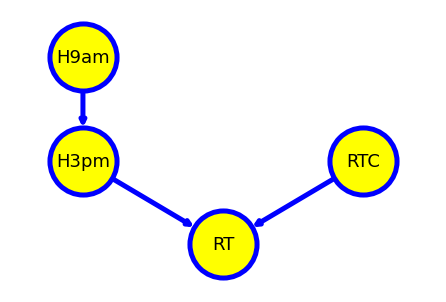

In [7]:
pos = {0: (0, 7), 1: (0, 2), 2: (4, 2), 3: (2, -2)}

# To set options for DAG graph looks
options = {
    "font_size": 18,
    "node_size": 4500,
    "node_color": "Yellow",
    "edgecolors": "Blue",
    "edge_color": "Blue",
    "linewidths": 5,
    "width": 5,}
    
# To generate DAG graph
n, d = bbn.to_nx_graph()
nx.draw(n, with_labels = True, labels = d, pos = pos, **options)

# To update margins and plot the  DAG graph
ax = plt.gca()
ax.margins(0.2)
plt.axis("off")
plt.show()

In [8]:
# Function to  calculate marginal probabilities
def print_probs():
    for node in join_tree.get_bbn_nodes():
        potential = join_tree.get_bbn_potential(node)
        print("Node:", node)
        print("Values:")
        print(potential)
        print('-------------------------')
        
#printing marginal probabilities
print_probs()

Node: 1|H3pm|<=60,>60
Values:
1=<=60|0.67124
1=>60|0.32876
-------------------------
Node: 0|H9am|<=60,>60
Values:
0=<=60|0.30658
0=>60|0.69342
-------------------------
Node: 2|RTC|No,Yes
Values:
2=No|0.76890
2=Yes|0.23110
-------------------------
Node: 3|RT|No,Yes
Values:
3=No|0.78283
3=Yes|0.21717
-------------------------


In [9]:
# Add evidence of events that already happened so that probability distribution can be recalculated
def evidence(evidence, nod, category, value):
    evidence = EvidenceBuilder() \
    .with_node(join_tree.get_bbn_node_by_name(nod)) \
    .with_evidence(category, value) \
    .build()
    join_tree.set_observation(evidence)
    

In [10]:
# Calling evidence function to add evidence
evidence('Evidence1', 'H9am', '>60', 1.0)

# Printing marginal probabilities
print_probs()

Node: 1|H3pm|<=60,>60
Values:
1=<=60|0.55760
1=>60|0.44240
-------------------------
Node: 0|H9am|<=60,>60
Values:
0=<=60|0.00000
0=>60|1.00000
-------------------------
Node: 2|RTC|No,Yes
Values:
2=No|0.76890
2=Yes|0.23110
-------------------------
Node: 3|RT|No,Yes
Values:
3=No|0.75110
3=Yes|0.24890
-------------------------


In [11]:
# Adding more evidences
evidence('Evidence1', 'RTC', 'Yes', 1.0)
evidence('Evidence2' , 'H3pm', '>60',1.0)

# Printing marginal probabilities
print_probs()

Node: 1|H3pm|<=60,>60
Values:
1=<=60|0.00000
1=>60|1.00000
-------------------------
Node: 0|H9am|<=60,>60
Values:
0=<=60|0.00000
0=>60|1.00000
-------------------------
Node: 2|RTC|No,Yes
Values:
2=No|0.00000
2=Yes|1.00000
-------------------------
Node: 3|RT|No,Yes
Values:
3=No|0.38643
3=Yes|0.61357
-------------------------
